# Data Cleaning
In this notebook I clean and prepare the Yelp review data for modeling. In addition, I do some data exploration to understand the dataset.

## Setup

Import Python libraries.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import spacy
import sys

from google.colab import drive
from importlib.machinery import SourceFileLoader

%matplotlib inline

Mount Google drive

In [0]:
ROOT = '/content/drive'
PROJECT = 'My Drive/Thinkful/Final_Capstone_Project/'
PROJECT_PATH = os.path.join(ROOT, PROJECT)

In [0]:
# drive.mount(ROOT)

Load custom constants and methods.

In [0]:
con = SourceFileLoader('constants', os.path.join(PROJECT_PATH, 'utilities/constants.py')).load_module()
met = SourceFileLoader('methods', os.path.join(PROJECT_PATH, 'utilities/methods.py')).load_module()

## Load Data
Read in businesses data into a Pandas **`DataFrame`**.

In [0]:
df_businesses = pd.read_csv(os.path.join(PROJECT_PATH, 'data/businesses.csv'))

In [21]:
df_businesses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
id              1000 non-null object
name            1000 non-null object
is_closed       1000 non-null bool
review_count    1000 non-null int64
rating          1000 non-null float64
distance        1000 non-null float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 40.2+ KB


In [22]:
num_unique_businesses = len(df_businesses['id'].unique())
print(f"There are {num_unique_businesses} unique businesses.")

There are 1000 unique businesses.


In [23]:
num_closed_businesses = df_businesses['is_closed'].sum()
print(f"The dataset contains {num_closed_businesses} closed businesses.")

The dataset contains 0 closed businesses.


Read in reviews data into a Pandas **`DataFrame`**.

In [0]:
df_reviews = pd.read_csv(os.path.join(PROJECT_PATH, 'data/full_reviews.csv'))

In [25]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300 entries, 0 to 19299
Data columns (total 2 columns):
rating    19300 non-null int64
text      19300 non-null object
dtypes: int64(1), object(1)
memory usage: 301.7+ KB


In [26]:
print(f'The dataset consists of {len(df_reviews)} reviews.')

The dataset consists of 19300 reviews.


## Data Exploration
### Ratings
Let's look at the distribution of restaurant ratings.

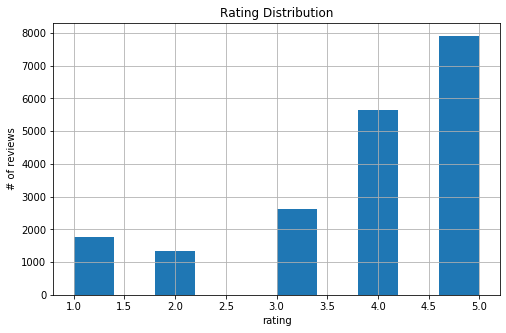

In [27]:
df_reviews['rating'].hist(figsize=(8, 5))
plt.title('Rating Distribution')
plt.xlabel('rating')
plt.ylabel('# of reviews')
plt.savefig(os.path.join(PROJECT_PATH, 'images/rating_distribution.png'))
plt.show()

I will use the ratings as the labels when I perform the modeling. Since I am only interested in positive and negative reviews, I will divide the ratings into two groups. Since review ratings for 3 are mediocre reviews, I will exclude these from the analysis. This will make the positive and negative groups more distinct. The positive reviews will be those with ratings for 4 and 5 and will be labeled as 0. The negative reviews will be those with ratings of 1 and 2 and will be labeled with a 1.

In [0]:
df_reviews = df_reviews[df_reviews['rating'] != 3].copy()

In [0]:
ratings = df_reviews['rating'].values
negative_ratings = ratings <= 2
df_reviews['labels'] = negative_ratings.astype(int)

In [30]:
print(f'There are {df_reviews["labels"].sum()} negative reviews.')
print(f'There are {len(df_reviews) - df_reviews["labels"].sum()} positive reviews.')

There are 3104 negative reviews.
There are 13564 positive reviews.


In [31]:
num_postive_reviews = len(df_reviews) - df_reviews["labels"].sum()
positive_review_ratio = num_postive_reviews / len(df_reviews)
print(f'The fraction of positive reviews in this dataset is {positive_review_ratio:0.3f}')

The fraction of positive reviews in this dataset is 0.814


This dataset is clearning highly skewed. I will address this issue during the modeling phase.

### Reviews
Now let's investigate review lengths. First, we can look at review lengths in terms of number of characters.

In [0]:
df_reviews['character_count'] = df_reviews['text'].apply(lambda x: len(''.join(x.split())))

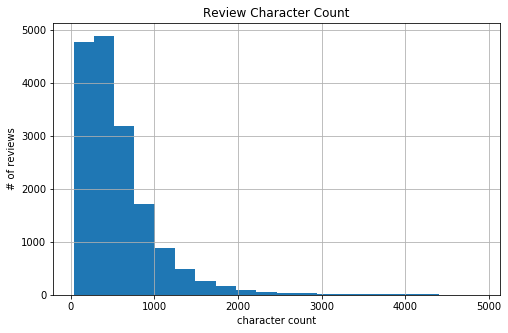

In [33]:
df_reviews['character_count'].hist(bins=20, figsize=(8, 5))
plt.title('Review Character Count')
plt.xlabel('character count')
plt.ylabel('# of reviews')
plt.savefig(os.path.join(PROJECT_PATH, 'images/character_count.png'))
plt.show()

Now, let's look at the distribution of word counts for each review.

In [0]:
df_reviews['word_count'] = df_reviews['text'].apply(lambda x: len(x.split()))

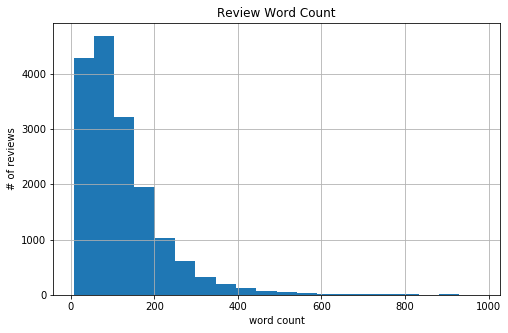

In [35]:
df_reviews['word_count'].hist(bins=20, figsize=(8, 5))
plt.title('Review Word Count')
plt.xlabel('word count')
plt.ylabel('# of reviews')
plt.savefig(os.path.join(PROJECT_PATH, 'images/word_count.png'))
plt.show()

We can compare rating, character count, and review count together using the `describe()` method in Pandas.

In [36]:
df_reviews.loc[:, ['rating', 'character_count', 'word_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,16668.0,3.995920,1.323068,1.0,4.0,4.0,5.0,5.0
character_count,16668.0,562.830334,462.519740,33.0,248.0,443.0,725.0,4887.0
word_count,16668.0,122.100432,99.032238,7.0,54.0,97.0,159.0,978.0


Most reviews range around 120 words, while one review has only 9 words and another has almost 1000 words.

## Data Cleaning
Before passing the review data on to the modeling phase, there are several preprocessing steps that need to be taken. I will perform pre-processing of the text data in the reviews using [Spacy](https://spacy.io/).

In [0]:
# Load Spacy's toolset
nlp = spacy.load("en_core_web_sm")

### Tokenization
The first step is to split the words in the reviews into tokens. This is called tokenization. Spacy will not only tokenize each word, it will also tokenize the punctuation.

Before tokenization, the raw text looks like this:

In [38]:
df_reviews.loc[:5, 'text']

0    A friend and I randomly picked this place out ...
2    Great food. Weak service, even at the bar. <br...
3    I came for the drinks and they did not disappo...
4    I've been here for HH on a number of occasions...
5    Small and cozy place. Staff is friends and att...
Name: text, dtype: object

In [0]:
df_reviews['text_split'] = df_reviews['text'].apply(lambda x: [y.text for y in nlp(x)])

After tokenization, the review text becomes a list of words:

In [40]:
df_reviews.loc[:5, 'text_split']

0    [A, friend, and, I, randomly, picked, this, pl...
2    [Great, food, ., Weak, service, ,, even, at, t...
3    [I, came, for, the, drinks, and, they, did, no...
4    [I, 've, been, here, for, HH, on, a, number, o...
5    [Small, and, cozy, place, ., Staff, is, friend...
Name: text_split, dtype: object

### Lemmatization
We can also convert the text data into tokenized lemma's. A lemma is the most basic form for a word. For example, the word _picked_ will be changed to _pick_, converting the past tense of the word to its present tense.

In [0]:
df_reviews['lemma'] = df_reviews['text'].apply(lambda x: [y.lemma_ for y in nlp(x)])

Here you can see how the lemmanization changed the tokenized words:

In [42]:
df_reviews.loc[:5, 'lemma']

0    [a, friend, and, -PRON-, randomly, pick, this,...
2    [great, food, ., weak, service, ,, even, at, t...
3    [-PRON-, come, for, the, drink, and, -PRON-, d...
4    [-PRON-, have, be, here, for, HH, on, a, numbe...
5    [small, and, cozy, place, ., staff, be, friend...
Name: lemma, dtype: object

### Stop Words
Stop words are insignicant words with little real meanings related to the overall context of a document. Spacy contains a large list of stop words. These can be used to tag the words in the corpus of review documents with boolean values to flag whether they are stop words or not.

In [0]:
df_reviews['stop'] = df_reviews['text'].apply(lambda x: [y.is_stop for y in nlp(x)])

Each token has now been labeled with a boolean value, flagging whether it is a stop word or not:

In [44]:
df_reviews.loc[:5, 'stop']

0    [True, False, True, True, False, False, True, ...
2    [False, False, False, False, False, False, Tru...
3    [True, False, True, True, False, True, True, T...
4    [True, True, True, True, True, False, True, Tr...
5    [False, True, False, False, False, False, True...
Name: stop, dtype: object

Let's compare the relationship between the total word counts in each document with the number of stop words in each document.

In [0]:
df_reviews['word_count'] = df_reviews['text_split'].apply(lambda x: len(x))

In [0]:
df_reviews['stop_count'] = df_reviews['stop'].apply(lambda x: np.sum(x))

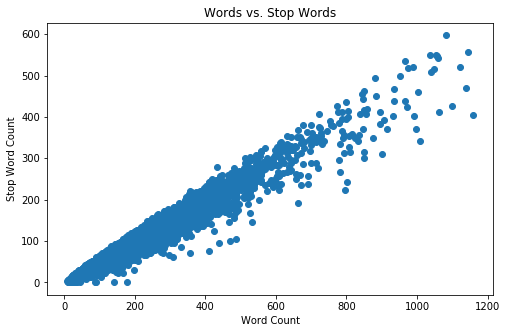

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df_reviews['word_count'], df_reviews['stop_count'])
ax.set_title('Words vs. Stop Words')
ax.set_xlabel('Word Count')
ax.set_ylabel('Stop Word Count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/words_vs_stop_words.png'))
plt.show()

In [0]:
df_reviews['stop_word_fraction'] = df_reviews['stop_count'] / df_reviews['word_count']

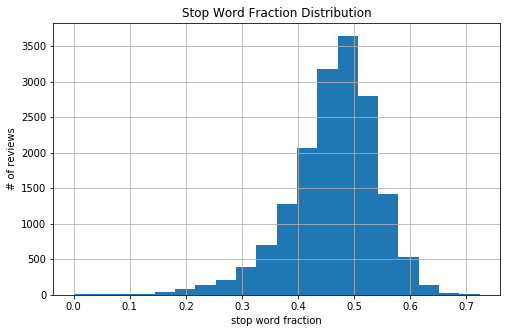

In [62]:
df_reviews['stop_word_fraction'].hist(bins=20, figsize=(8, 5))
plt.title('Stop Word Fraction Distribution')
plt.xlabel('stop word fraction')
plt.ylabel('# of reviews')
plt.savefig(os.path.join(PROJECT_PATH, 'images/stop_word_fraction.png'))
plt.show()

The distribution in stop word counts is roughly normal, with most reviews consisting of a little under 50% of stop words.

I will now remove the stop words from each review.

In [0]:
def filter_stop_words(lemma, stop):
  clean_words = [not x for x in stop]
  clean_array = np.array(clean_words)
  lemma_array = np.array(lemma)
  return list(lemma_array[clean_array])

In [0]:
df_reviews['stop_free'] = df_reviews.apply(lambda x: filter_stop_words(x['lemma'], x['stop']), axis=1)

The tokenized words now become:

In [52]:
df_reviews.loc[:5, 'stop_free']

0    [friend, randomly, pick, place, handful, place...
2    [great, food, ., weak, service, ,, bar, ., <, ...
3    [come, drink, disappoint, ., highly, recommend...
4    [HH, number, occasion, remember, food, lot, ta...
5    [small, cozy, place, ., staff, friend, attenti...
Name: stop_free, dtype: object

### Non-alpha Words
I will also filter out tokens that are not alpha, string, words. This will remove numeric values as well as punctuation.

In [0]:
df_reviews['clean_text'] = df_reviews['stop_free'].apply(lambda x: [y for y in x if y.isalpha()])

In [54]:
df_reviews.loc[:5, 'clean_text']

0    [friend, randomly, pick, place, handful, place...
2    [great, food, weak, service, bar, small, place...
3    [come, drink, disappoint, highly, recommend, c...
4    [HH, number, occasion, remember, food, lot, ta...
5    [small, cozy, place, staff, friend, attentive,...
Name: clean_text, dtype: object

In [0]:
df_reviews['clean_word_count'] = df_reviews['clean_text'].apply(lambda x: len(x))

We can now compare the word counts of the cleaned reviews, grouped by label, using a BoxPlot.

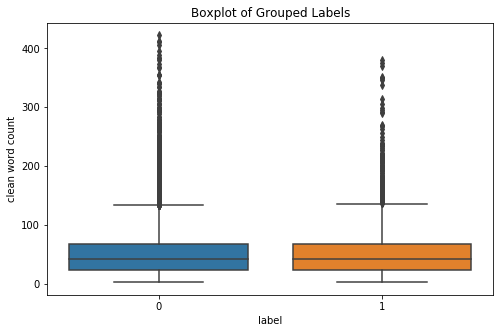

In [56]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='labels', y='clean_word_count', data=df_reviews, ax=ax)
ax.set_xlabel('label')
ax.set_ylabel('clean word count')
ax.set_title('Boxplot of Grouped Labels')
plt.savefig(os.path.join(PROJECT_PATH, 'images/grouped_labels_boxplot.png'))
plt.show()

The distributions in word count between positive and negative reviews appear fairly similar.

## Vocabulary Size
Now that the dataset is clean, I can calculate the vocabulary size. The **vocabulary** is the set of all unique words in the corpus. The **corpus** is the collection of text for all of the reviews.

In [57]:
cleaned_corpus = []
for document in df_reviews['clean_text'].values:
  cleaned_corpus += document
vocab = np.unique(cleaned_corpus)
vocab_size = len(vocab)
print(f'The corpus size is {len(cleaned_corpus)}.')
print(f'The vocabulary size is {vocab_size}.')

The corpus size is 887539.
The vocabulary size is 27886.


### Tokens to Sequences
Lastly, I will merge the tokens into sequences of strings. Some of the models I will use prefer this kind of data structure.

In [0]:
df_reviews['text_seq'] = df_reviews['clean_text'].apply(lambda x: (' '.join(x)))

In [59]:
df_reviews.loc[:5, 'text_seq']

0    friend randomly pick place handful place visit...
2    great food weak service bar small place know n...
3    come drink disappoint highly recommend come vi...
4    HH number occasion remember food lot tasty yea...
5    small cozy place staff friend attentive try po...
Name: text_seq, dtype: object

The final, cleaned dataset consists of the following columns:

In [60]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16668 entries, 0 to 19299
Data columns (total 14 columns):
rating                16668 non-null int64
text                  16668 non-null object
labels                16668 non-null int64
character_count       16668 non-null int64
word_count            16668 non-null int64
text_split            16668 non-null object
lemma                 16668 non-null object
stop                  16668 non-null object
stop_count            16668 non-null int64
stop_word_fraction    16668 non-null float64
stop_free             16668 non-null object
clean_text            16668 non-null object
clean_word_count      16668 non-null int64
text_seq              16668 non-null object
dtypes: float64(1), int64(6), object(7)
memory usage: 2.5+ MB


## Save Cleaned Data
The dataset has now been cleaned and the text has been preprocessed for modeling. I will save it to a csv file, which I can load during modeling.

In [0]:
df_reviews.loc[:, ['text', 'clean_text', 'text_seq', 'labels']].to_csv(os.path.join(PROJECT_PATH, 'data/cleaned_full.csv'), index=False)